In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
USE_GPU = True
from model import *
from data_loaders import load_mnist
from tools import weights_init_xavier
import matplotlib.pyplot as plt
import os.path as path
SAVE_DIR = "saved_models"
FILENAME = "model63.pt"

In [2]:
def initialize_weights(capsnet, initializer):
  capsnet.conv_layer.conv.apply(initializer)
  capsnet.primary_capsules.apply(initializer)
  capsnet.decoder.apply(initializer)
  #nn.init.xavier_normal_(capsnet.digit_caps.W)

In [3]:
capsnet = CapsNet()
if USE_GPU:
  capsnet.cuda()
optimizer = torch.optim.Adam(capsnet.parameters())

In [4]:
filepath = path.join(SAVE_DIR, FILENAME)
if path.isfile(filepath):
  print("Saved model found")
  capsnet.load_state_dict(torch.load(filepath))
else:
  print("Saved model not found; Model initialized.")
  capsnet.initialize_weights(weights_init_xavier)

Saved model found


In [47]:
"""Hyperparameters"""
max_epochs = 1000
batch_size = 128
train_loader, test_loader = load_mnist(batch_size)

In [37]:
t = time.time()
Te_LOSS = []
Tr_LOSS = []
test_acc = []
display_step = 450
for epoch in range(max_epochs):
  capsnet.train()
  train_loss = 0
  for batch, (data, target) in list(enumerate(train_loader)):
    target = torch.eye(10).index_select(dim=0, index=target)
    data, target = Variable(data), Variable(target)
    
    if USE_GPU:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()
    
    output, reconstructions, masked = capsnet(data, target)
    loss = capsnet.loss(data, target, output, reconstructions)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.data.item()
    if batch % display_step == 0 and batch != 0:
      eval_time = time.time()

      capsnet.eval()
      test_loss = 0
      test_correct = 0
      test_total = 0
      for batch_id, (data, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_GPU:
          data,target = data.cuda(), target.cuda()

        output, reconstruction, masked = capsnet(data)
        loss = capsnet.loss(data, target, output, reconstruction)

        test_loss += loss.data.item()
        test_total += data.size(0)
        test_correct += sum(np.argmax(masked.data.cpu().numpy(),1 ) == np.argmax(target.data.cpu().numpy(), 1))

      acc = test_correct / test_total
      Te_LOSS.append(test_loss / len(test_loader))
      Tr_LOSS.append(train_loss / len(train_loader))
      test_acc.append(acc)
      test_loss /= len(test_loader)
      train_loss /= len(train_loader)
      time_spent = time.time() - t
      t = time.time()
      
      print("Epoch: {:3.0f} \t Time: {:3.0f} \t Test: {:.3f} \t Train: {:.3f} \t Accuracy: {:3.4f}".format(epoch, time_spent,test_loss, train_loss, acc*100))
      train_loss = 0
      filepath = path.join(SAVE_DIR, "model{}.pt".format(epoch))
      torch.save(capsnet.state_dict(), filepath)
      capsnet.train()
  

KeyboardInterrupt: 

In [39]:
capsnet.eval()
data, target = iter(test_loader).next()
output, reconstruction, masked = capsnet(data.cuda())

In [40]:
predictions = torch.max((output**2).sum(dim=2).squeeze(), dim=1)[1].cpu().data.numpy()

tensor(0) 0


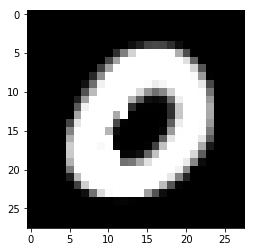

In [45]:
i = 3
print(target[i], predictions[i])
im = reconstruction[i,0].data.cpu().numpy()
im += abs(im.min())
im /= im.max()
plt.imshow(im, cmap="gray")